# TCAV short implementation
### original paper: https://arxiv.org/pdf/1711.11279.pdf

In [1]:
import numpy as np
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import decode_predictions
import skimage
import matplotlib.pyplot as plt
import keras.backend as K
from vis.utils import utils
from os import listdir
import random
from sklearn import linear_model
from sklearn.model_selection import train_test_split
import tensorflow as tf

Using TensorFlow backend.


In [2]:
def img_preprocess(img):

    min_img_range = -1
    max_img_range = 1
    img = skimage.transform.resize(img,(299,299,3), mode='constant', anti_aliasing=False) ## anti_aliasing has to be False
#     img = skimage.transform.resize(img,(299,299,3))
    img = min_img_range + img * (max_img_range-min_img_range)
    
    return img


def get_cav(concept_act_s,random_act_s,concept_lbl_s, random_lbl_s, clf_type = 'sgd'):

    X = np.vstack([concept_act_s,random_act_s])
    # X = (X-np.mean(X))/np.std(X)
    y = np.hstack([concept_lbl_s, random_lbl_s])
    X_tr, X_vl, y_tr, y_vl = train_test_split(X, y, shuffle= True)
    
    print('X train size: ',X_tr.shape)
    print('y train size: ',y_tr.shape)
    print('X valid size: ',X_vl.shape)
    print('y valid size: ',y_vl.shape)
    
    if clf_type == 'sgd':
        clf = linear_model.SGDClassifier(alpha=.01)
        
    elif clf_type == 'logistic':
        clf = linear_model.LogisticRegression()
        
    clf.fit(X_tr, y_tr)
    
    print('Training score: ',clf.score(X_tr, y_tr))
    print('Validation score: ',clf.score(X_vl, y_vl))

    cavs = [-1 * clf.coef_[0], clf.coef_[0]]  ## cavs[0]: stripes, cavs[1]: no_stripes
    
    return cavs



def get_directional_derivative(img, model, layer_name, cav):

    sess = K.get_session()
    grad_out_wrt_layer = K.gradients(model.output, model.get_layer(layer_name).output)[0] # Gradient of output wrt the layer of the model 
    grad_sample_activation = sess.run(grad_out_wrt_layer, feed_dict={model.input: np.expand_dims(img,0)})
    directional_derivative = np.dot(np.reshape(grad_sample_activation.flatten(),-1),cav)
    sign_dir_der = directional_derivative < 0
    
    return sign_dir_der, directional_derivative

### define model and function to access layer activations

In [25]:
model = InceptionV3(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)
model.summary()

In [4]:
layer_name = 'activation_94'
lay_idx = utils.find_layer_idx(model, layer_name)
get_layer_activation = K.function([model.input], [model.layers[lay_idx].output])

Flat activation size:  12288


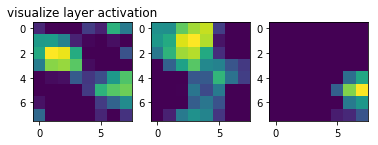

In [31]:
img = skimage.io.imread('images/tiger.jpg')
img = img_preprocess(img)

plt.imshow(img[:,:,2])
plt.colorbar()

activation = np.squeeze(get_layer_activation([np.expand_dims(img,0)])[0])
print('Flat activation size: ', activation.flatten().shape[0])


plt.subplot(1,3,1)
plt.title('visualize layer activation')
plt.imshow(activation[:,:,0])
plt.subplot(1,3,2)
plt.imshow(activation[:,:,1])
plt.subplot(1,3,3)
plt.imshow(activation[:,:,2])



### create cav dataset (i.e. stripes vs no-stripes)
#### Texture dataset: https://www.robots.ox.ac.uk/~vgg/data/dtd/index.html

In [21]:
! rm /Users/yc00088/Documents/Affective_computing/datasets/patterns/images/.DS_Store
path = '/Users/yc00088/Documents/Affective_computing/datasets/patterns/images/{0}/'
patterns = listdir('/Users/yc00088/Documents/Affective_computing/datasets/patterns/images/')
for p in patterns: print(p)

In [8]:
tgt_patterns = ['striped', 'banded', 'lined']
rnd_patterns = patterns
for patt in tgt_patterns: rnd_patterns.remove(patt)

In [22]:
### concept set

concept_act_s = []
concept_lbl_s = []

for patt in tgt_patterns:

    for file in listdir(path.format(patt)):
        
        img_path = path.format(patt)+file
        print(patt,'-',file)
#         print(img_path)
        
        img = skimage.io.imread(img_path)
        img = img_preprocess(img)
        activation = np.squeeze(get_layer_activation([np.expand_dims(img,0)])[0])

        concept_act_s.append(activation.flatten())
        concept_lbl_s.append(0)
        

In [23]:
### random set

random_act_s = []
random_lbl_s = []


for i in range(len(concept_act_s)):

    patt = random.choice(rnd_patterns)
    file = random.choice(listdir(path.format(patt)))
    img_path = path.format(patt)+file
    print(patt,'-',file)
#     print(img_path)

    img = skimage.io.imread(img_path)
    img = img_preprocess(img)
    activation = np.squeeze(get_layer_activation([np.expand_dims(img,0)])[0])

    random_act_s.append(activation.flatten())
    random_lbl_s.append(1)
    

### train cavs

In [17]:
cavs = get_cav(concept_act_s,random_act_s,concept_lbl_s, random_lbl_s, clf_type='logistic')
print(cavs)
print('cav shape: ', cavs[0].shape)

X train size:  (540, 12288)
y train size:  (540,)
X valid size:  (180, 12288)
y valid size:  (180,)


/anaconda3/envs/py36_GM/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Training score:  1.0
Validation score:  0.9444444444444444
[array([ 0.00395637,  0.01529996, -0.005769  , ..., -0.02334973,
       -0.00829141, -0.0049361 ]), array([-0.00395637, -0.01529996,  0.005769  , ...,  0.02334973,
        0.00829141,  0.0049361 ])]
cav shape:  (12288,)


### test presence of concept in image class
The concept should be present in classes where this contributes to the classification (eg. stripes in zebra) but should not be present in classes where this is just coincidental (eg. stripes in a tshirt)

[('n02389026', 'sorrel', 0.86930263), ('n03538406', 'horse_cart', 0.0021652956), ('n04604644', 'worm_fence', 0.0013041479), ('n03124170', 'cowboy_hat', 0.001227479), ('n02795169', 'barrel', 0.0010680328)]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


predicted class:  ('n02389026', 'sorrel', 0.86930263)
presence of concept stripe in sample:  False
directional_derivative:  3.0291588257430774e-10


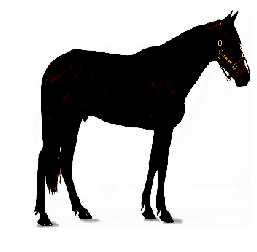

[('n02206856', 'bee', 0.9450983), ('n02190166', 'fly', 0.022231372), ('n02727426', 'apiary', 0.0054665343), ('n03530642', 'honeycomb', 0.0045761233), ('n02219486', 'ant', 0.0016561534)]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


predicted class:  ('n02206856', 'bee', 0.9450983)
presence of concept stripe in sample:  True
directional_derivative:  -8.93342688805427e-11


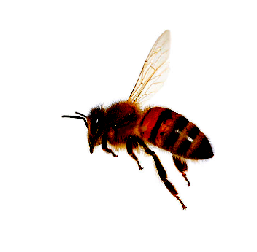

[('n02391049', 'zebra', 0.9545049), ('n01518878', 'ostrich', 0.0007821033), ('n03447447', 'gondola', 0.000762501), ('n02422106', 'hartebeest', 0.00072065264), ('n02437312', 'Arabian_camel', 0.00037266986)]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


predicted class:  ('n02391049', 'zebra', 0.9545049)
presence of concept stripe in sample:  True
directional_derivative:  -9.680564432939853e-09


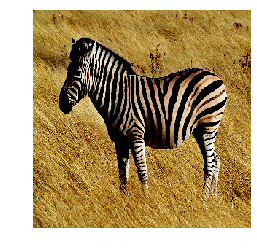

[('n02129604', 'tiger', 0.893475), ('n02123159', 'tiger_cat', 0.082356036), ('n02391049', 'zebra', 0.00048326346), ('n02127052', 'lynx', 0.00041435054), ('n02128925', 'jaguar', 0.00039238416)]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


predicted class:  ('n02129604', 'tiger', 0.893475)
presence of concept stripe in sample:  True
directional_derivative:  -2.5946516267960685e-09


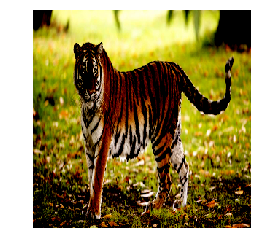

[('n03595614', 'jersey', 0.6619003), ('n03710637', 'maillot', 0.24279018), ('n02807133', 'bathing_cap', 0.013683634), ('n03877472', 'pajama', 0.012048875), ('n04599235', 'wool', 0.00935919)]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


predicted class:  ('n03595614', 'jersey', 0.6619003)
presence of concept stripe in sample:  False
directional_derivative:  2.476715791417798e-10


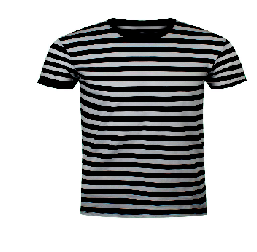

[('n03100240', 'convertible', 0.5824325), ('n04285008', 'sports_car', 0.2560292), ('n02974003', 'car_wheel', 0.010130927), ('n04037443', 'racer', 0.0035172687), ('n03459775', 'grille', 0.0027513579)]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


predicted class:  ('n03100240', 'convertible', 0.5824325)
presence of concept stripe in sample:  False
directional_derivative:  5.652977836153884e-10


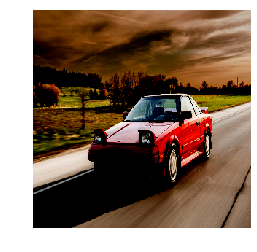

[('n02389026', 'sorrel', 0.72262317), ('n02422106', 'hartebeest', 0.011589447), ('n03538406', 'horse_cart', 0.007395794), ('n09428293', 'seashore', 0.0034986301), ('n02437312', 'Arabian_camel', 0.0025091034)]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


predicted class:  ('n02389026', 'sorrel', 0.72262317)
presence of concept stripe in sample:  True
directional_derivative:  -2.189243503633456e-10


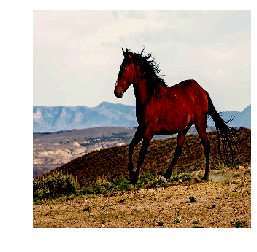

[('n02389026', 'sorrel', 0.7999498), ('n02422106', 'hartebeest', 0.038883496), ('n03538406', 'horse_cart', 0.0027136214), ('n02106030', 'collie', 0.0023115359), ('n04604644', 'worm_fence', 0.001868094)]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


predicted class:  ('n02389026', 'sorrel', 0.7999498)
presence of concept stripe in sample:  False
directional_derivative:  6.725634268074861e-10


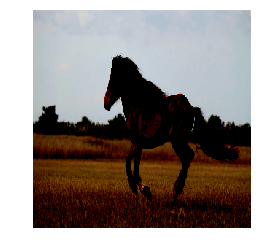

In [20]:
for file in listdir('images'):

    img = skimage.io.imread('images/'+file)
    img = img_preprocess(img)
    pred = model.predict(np.expand_dims(img,0))#.flatten()
    prd_class = decode_predictions(pred)
    print(prd_class[0])

    stripe_cav = cavs[0]
    sign_dir_der, directional_derivative = get_directional_derivative(img, model, layer_name, stripe_cav)

    print('predicted class: ', prd_class[0][0])
    print('presence of concept stripe in sample: ', sign_dir_der)
    print('directional_derivative: ', directional_derivative)
    plt.imshow(img[:,:])
    plt.axis('off')
    plt.show()
    
#     break

In [31]:
### Next step: compute TCAV score for the class (i.e. % of images in class where cav=True)
### Next step: implement statistical test for CAV

In [32]:
## Resources
#
# https://stackoverflow.com/questions/54566337/how-to-get-gradient-values-using-keras-backend-gradients
# https://github.com/tensorflow/tcav/tree/master/tcav